# Timescales vs. TSNR (NKI 1400, HY, CompCorGSR, BNA)

In [1]:
# Parameters
dwi_data_label = "Yeh-HCP842"
results_dir = "/home/despo/dlurie/Projects/timescale_hierarchy/results"
resource_dir = "/home/despoB/dlurie/Projects/timescale_hierarchy/data/resources"
fmri_data_label = "NKI-1400_HY_CompCorGSR"
roi_subset = "CX"

In [2]:
import sys
import os
from glob import glob
from copy import copy
import pandas as pd
import pingouin as pg
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stat import S_IREAD, S_IRGRP, S_IROTH

/home/despoB/dlurie/anaconda3/envs/timescale/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/despoB/dlurie/anaconda3/envs/timescale/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
sys.path.append('/home/despo/dlurie/Projects/timescale_hierarchy/code/scripts/')
sys.path.append('/home/despo/dlurie/Projects/PyPALM/')

In [4]:
import pypalm as pm
import utils

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette("colorblind")
pal = copy(plt.cm.autumn_r)
pal.set_bad('lightgrey')

In [6]:
fmri_data_label = 'NKI-1400_HY_CompCorGSR'
results_dir = '/home/despoB/dlurie/Projects/timescale_hierarchy/results'
resource_dir = '/home/despoB/dlurie/Projects/timescale_hierarchy/data/resources'

In [7]:
subject_list = np.genfromtxt('/home/despoB/dlurie/Projects/timescale_hierarchy/data/meta/subject_lists/NKI-healthy_young.txt', dtype="U")

In [8]:
tsnr_fpt = '/home/despo/nki_rs/data/derivatives/custom/sub-{0}/func/sub-{0}_ses-*_task-rest_acq-1400_bold_space-MNI152NLin2009cAsym_atlas-BNA_desc-preproc_tsnr.csv'

In [9]:
PPtsnr_store = []
mean_store = []
sd_store = []
for sub in subject_list:
    try:
        PPtsnr_file = glob(tsnr_fpt.format(sub))[0]
        PPtsnr_data = pd.read_csv(PPtsnr_file, index_col=0)
        mean_store.append(PPtsnr_data.tmean.values)
        PPtsnr_store.append(PPtsnr_data.tsnr.values)
        sd_store.append(PPtsnr_data.tsd.values)
    except:
        print("No data found for subject {0}".format(sub))
        pass
PPtsnr_store = np.array(PPtsnr_store)
mean_store = np.array(mean_store)
sd_store = np.array(sd_store)

In [10]:
ts_df = pd.read_csv(f'{results_dir}/timescales/{fmri_data_label}_BNA_timescale_df.csv')

In [11]:
roi_vols = np.genfromtxt(f'{resource_dir}/BNA-maxprob-thr25-2mm_ROI_volumes.txt')

In [12]:
df = pd.DataFrame([ts_df.lag1_median, roi_vols, np.median(mean_store, axis=0),
                   np.median(PPtsnr_store, axis=0), np.median(sd_store, axis=0)]).T
df.columns = ['lag1','roi_vols','tmean','PPtsnr', 'tsd']

In [13]:
lag1_resid = smf.ols('lag1 ~ roi_vols', data=df).fit().resid + np.mean(df.lag1)
PPtsnr_resid = smf.ols('PPtsnr ~ roi_vols', data=df).fit().resid + np.mean(df.PPtsnr)
tmean_resid = smf.ols('tmean ~ roi_vols', data=df).fit().resid + np.mean(df.tmean)
sd_resid = smf.ols('tsd ~ roi_vols', data=df).fit().resid + np.mean(df.tsd)

In [14]:
df_resid = pd.DataFrame([lag1_resid, PPtsnr_resid, tmean_resid, sd_resid],
                       index=['Lag-1','tSNR','Mean', 'SD']).T

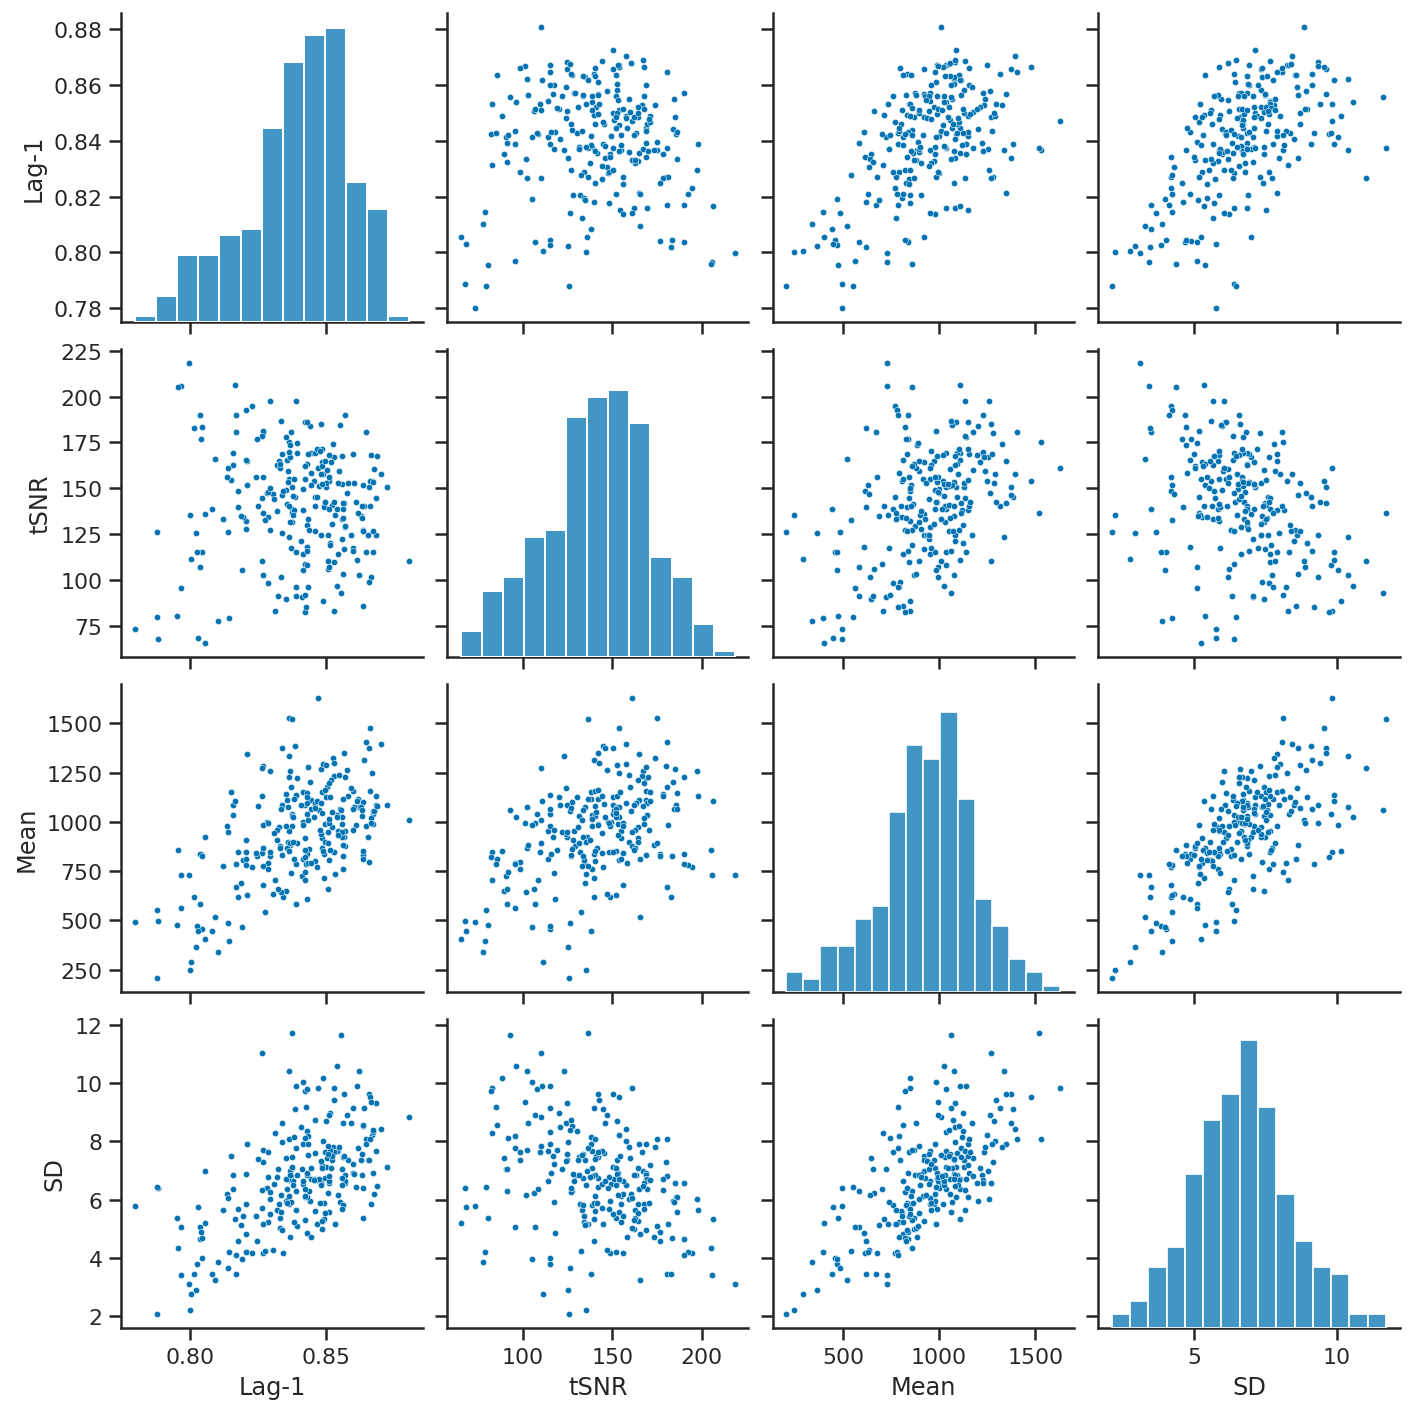

In [15]:
g = sns.pairplot(df_resid, plot_kws={'s':10})

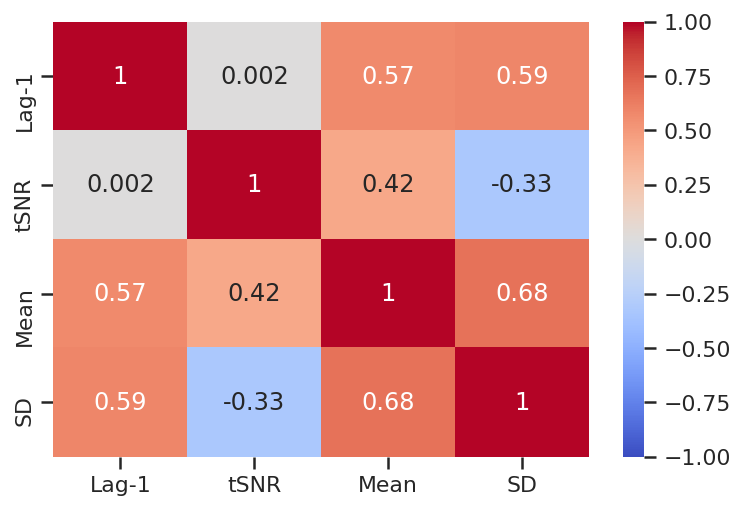

In [16]:
g = sns.heatmap(df_resid.corr(), annot=df_resid.corr(), cmap='coolwarm', vmin=-1, vmax=1)

### Compare lag-1 and basic signal properties between cortical and subcortical ROIS

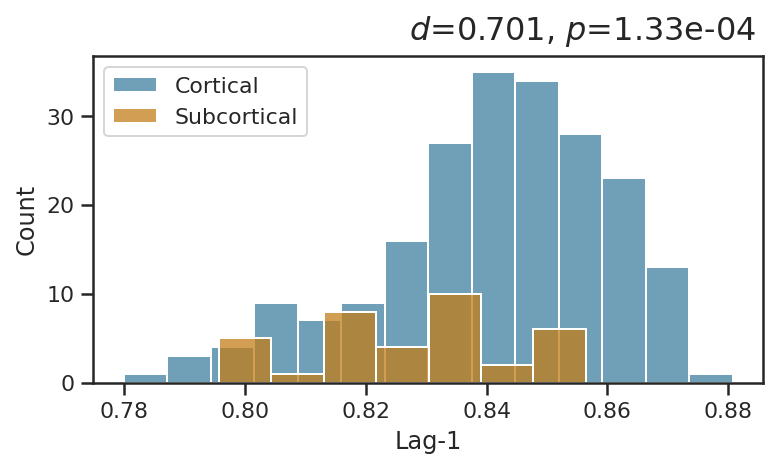

In [17]:
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,3))
sns.histplot(df_resid['Lag-1'][:210], color='#3F80A1', label='Cortical', ax=ax1)
sns.histplot(df_resid['Lag-1'][210:], color='#C27E19', label='Subcortical',ax=ax1)
plt.legend()
res = pg.ttest(df_resid['Lag-1'][:210], df_resid['Lag-1'][210:], correction='welch')
a = ax1.text(.99,1.05, "$\mathit{{d}}$={0:04.3f}, $\mathit{{p}}$={1:04.2e}".format(res['cohen-d'][0], res['p-val'][0]), 
            horizontalalignment='right', fontsize=16, transform=ax1.transAxes)

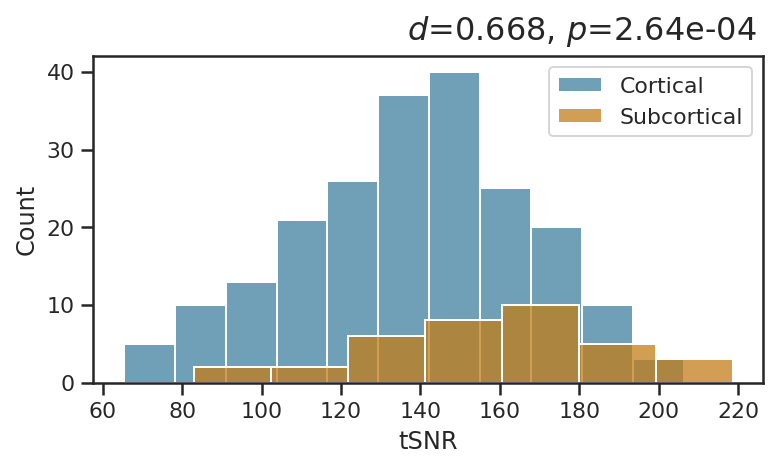

In [18]:
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,3))
sns.histplot(df_resid['tSNR'][:210], color='#3F80A1', label='Cortical', ax=ax1)
sns.histplot(df_resid['tSNR'][210:], color='#C27E19', label='Subcortical',ax=ax1)
plt.legend()
res = pg.ttest(df_resid['tSNR'][:210], df_resid['tSNR'][210:], correction='welch')
a = ax1.text(.99,1.05, "$\mathit{{d}}$={0:04.3f}, $\mathit{{p}}$={1:04.2e}".format(res['cohen-d'][0], res['p-val'][0]), 
            horizontalalignment='right', fontsize=16, transform=ax1.transAxes)

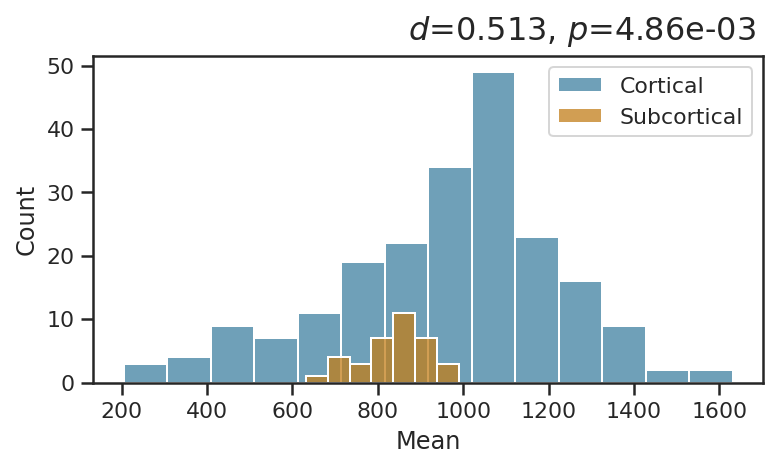

In [19]:
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,3))
sns.histplot(df_resid['Mean'][:210], color='#3F80A1', label='Cortical', ax=ax1)
sns.histplot(df_resid['Mean'][210:], color='#C27E19', label='Subcortical',ax=ax1)
plt.legend()
res = pg.ttest(df_resid['Mean'][:210], df_resid['Mean'][210:], correction='welch')
a = ax1.text(.99,1.05, "$\mathit{{d}}$={0:04.3f}, $\mathit{{p}}$={1:04.2e}".format(res['cohen-d'][0], res['p-val'][0]), 
            horizontalalignment='right', fontsize=16, transform=ax1.transAxes)

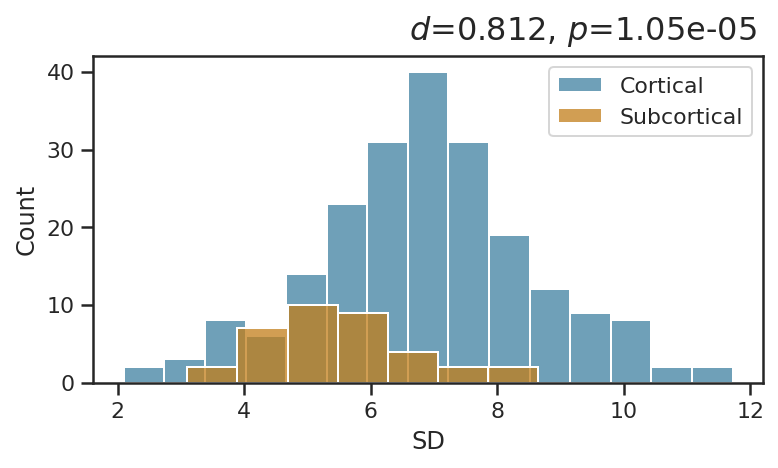

In [20]:
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,3))
sns.histplot(df_resid['SD'][:210], color='#3F80A1', label='Cortical', ax=ax1)
sns.histplot(df_resid['SD'][210:], color='#C27E19', label='Subcortical',ax=ax1)
plt.legend()
res = pg.ttest(df_resid['SD'][:210], df_resid['SD'][210:], correction='welch')
a = ax1.text(.99,1.05, "$\mathit{{d}}$={0:04.3f}, $\mathit{{p}}$={1:04.2e}".format(res['cohen-d'][0], res['p-val'][0]), 
            horizontalalignment='right', fontsize=16, transform=ax1.transAxes)

## Test correlation between lag-1 and basic signal properties (cortical ROIs only)

In [21]:
lag1_vs_roiv_yhatperm = np.load(f'{results_dir}/stats/timescale_associations/{fmri_data_label}_BNA_{roi_subset}_Lag1_vs_ROIv_yhatperms.npy')

In [22]:
df_cx = df[:210]

#### tSNR

In [24]:
lag1_vs_pptsnr_rval, lag1_vs_pptsnr_pvals, lag1_vs_pptsnr_model, lag1_vs_pptsnr_rnull = pm.freedman_lane(df_cx, 'lag1', 'PPtsnr', 'roi_vols',
                                                                                             stat='pcorr', n_perms=10000, perm_func=None,
                                                                                             perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm,
                                                                                             return_null=True, return_surrogates=False)

In [25]:
lag1_vs_pptsnr_rval

0.17458931405268593

In [26]:
lag1_vs_pptsnr_pvals

p_greater    0.210579
p_less       0.789521
p_abs        0.424558
dtype: float64

#### Mean

In [27]:
lag1_vs_AT_rval, lag1_vs_AT_pvals, lag1_vs_AT_model, lag1_vs_AT_rnull = pm.freedman_lane(df_cx, 'lag1', 'tmean', 'roi_vols',
                                                                                             stat='pcorr', n_perms=10000, perm_func=None,
                                                                                             perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm,
                                                                                             return_null=True, return_surrogates=False)

In [28]:
lag1_vs_AT_rval

0.5698309233633405

In [29]:
lag1_vs_AT_pvals

p_greater    0.004700
p_less       0.995400
p_abs        0.009999
dtype: float64

#### SD

In [30]:
lag1_vs_RT_rval, lag1_vs_RT_pvals, lag1_vs_RT_model, lag1_vs_RT_rnull = pm.freedman_lane(df_cx, 'lag1', 'tsd', 'roi_vols',
                                                                                             stat='pcorr', n_perms=10000, perm_func=None,
                                                                                             perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm,
                                                                                             return_null=True, return_surrogates=False)

In [31]:
lag1_vs_RT_rval

0.545340583084517

In [32]:
lag1_vs_RT_pvals

p_greater    0.0001
p_less       1.0000
p_abs        0.0001
dtype: float64